# Part 2: Train a model to recognize landmarks on Columbia’s campus.


The dataset that has been collected for this assignment contains three landmarks on Columbia's campus: Alma Mater, Scholars' Lion, and The Curl.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically between TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
!wget http://storage.googleapis.com/applied-deep-learning/landmark.zip\
    -O /tmp/landmark.zip

--2019-03-02 18:55:00--  http://storage.googleapis.com/applied-deep-learning/landmark.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99331917 (95M) [application/zip]
Saving to: ‘/tmp/landmark.zip’

/tmp/landmark.zip   100%[===================>]  94.73M  44.9MB/s    in 2.1s    

2019-03-02 18:55:03 (44.9 MB/s) - ‘/tmp/landmark.zip’ saved [99331917/99331917]



Extract the zip.

In [0]:
!ls '/tmp'

landmark.zip


In [0]:
local_zip = '/tmp/landmark.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/columbia_landmark')
zip_ref.close()

In [0]:
!ls '/tmp'

columbia_landmark  landmark.zip


In [0]:
!ls '/tmp/columbia_landmark/landmark'

test  train  val


In [0]:
base_dir = '/tmp/columbia_landmark/landmark'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_alma_dir = os.path.join(train_dir, 'alma_mater')
train_lion_dir = os.path.join(train_dir, 'scholars_lion')
train_curl_dir = os.path.join(train_dir, 'the_curl')

val_alma_dir = os.path.join(validation_dir, 'alma_mater')
val_lion_dir = os.path.join(validation_dir, 'scholars_lion')
val_curl_dir = os.path.join(validation_dir, 'the_curl')

test_alma_dir = os.path.join(test_dir, 'alma_mater')
test_lion_dir = os.path.join(test_dir, 'scholars_lion')
test_curl_dir = os.path.join(test_dir, 'the_curl')



## Explore the data

See how many images we have in each directory

In [0]:
num_alma_tr = len(os.listdir(train_alma_dir))
num_lion_tr = len(os.listdir(train_lion_dir))
num_curl_tr = len(os.listdir(train_curl_dir))

num_alma_val = len(os.listdir(val_alma_dir))
num_lion_val = len(os.listdir(val_lion_dir))
num_curl_val = len(os.listdir(val_curl_dir))


num_alma_test = len(os.listdir(test_alma_dir))
num_lion_test = len(os.listdir(test_lion_dir))
num_curl_test = len(os.listdir(test_curl_dir))


total_train = num_alma_tr + num_lion_tr + num_curl_tr
total_val = num_alma_val + num_lion_val + num_curl_val
total_test = num_alma_test + num_lion_test + num_curl_test



In [0]:
print('Training alma images:', num_alma_tr)
print('Training lion images:', num_lion_tr)
print('Training curl images:', num_curl_tr)

print('Validation alma images:', num_alma_val)
print('Validation lion images:', num_lion_val)
print('Validation curl images:', num_curl_val)

print('Test alma images:', num_alma_test)
print('Test lion images:', num_lion_test)
print('Test curl images:', num_curl_test)

print('--')

print('Total training images:', total_train)
print('Total validation images:', total_val)
print('Total test images:', total_test)


Training alma images: 149
Training lion images: 199
Training curl images: 174
Validation alma images: 69
Validation lion images: 74
Validation curl images: 69
Test alma images: 29
Test lion images: 40
Test curl images: 25
--
Total training images: 522
Total validation images: 212
Total test images: 94


## Reading images off disk

In [0]:
#read the images off disk
#resize each image to be 150*150 pixels

TARGET_SHAPE = 150
BATCH_SIZE = 32

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=45,
                                          width_shift_range=.15,
                                          height_shift_range=.15,
                                           horizontal_flip=True,
                                           zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
#load images from disk and resize them into the required dimensions

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                           class_mode='categorical')

Found 522 images belonging to 3 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=validation_dir,
                                                          target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                           class_mode = 'categorical')

Found 212 images belonging to 3 classes.


In [0]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=test_dir,
                                                          target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                           class_mode = 'categorical')

Found 93 images belonging to 3 classes.


In [0]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [0]:
sample_training_images.shape

(32, 150, 150, 3)

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

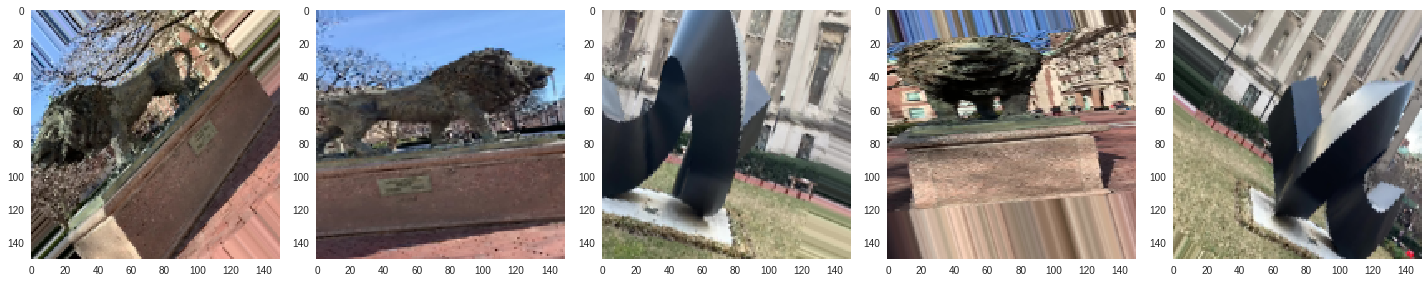

In [0]:
#plot first 5 images in the training set
plotImages(sample_training_images[:5])

## Transfer Learning

In [0]:
#initialize a VGG16 model preloaded with weights trained on ImageNet

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____

Here the number of parameters in the VGG16 model is Here the number of parameters in the VGG19 model is 24,220,739.

In [0]:
### Caching
TARGET_SHAPE = 150
BATCH_SIZE = 32

In [0]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count, 3))
  generator = datagen.flow_from_directory(
      directory,
      target_size = (TARGET_SHAPE, TARGET_SHAPE),
      batch_size = BATCH_SIZE,
      class_mode = 'categorical'
  )
  
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    
    features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
    labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
    
    i += 1
    
    if i * BATCH_SIZE >= sample_count:
      break
      
  return features, labels


train_features, train_labels = extract_features(train_dir, 522)
validation_features, validation_labels = extract_features(validation_dir, 212)
test_features, test_labels = extract_features(test_dir, 93)

Found 522 images belonging to 3 classes.
Found 212 images belonging to 3 classes.
Found 93 images belonging to 3 classes.


In [0]:
# Flatten the features

FLATTENED_SHAPE = 4 * 4 * 512
total_test = 93

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
test_features = np.reshape(test_features, (total_test, FLATTENED_SHAPE))

In [0]:
# Define a model, train it using the features extracted from VGG16
EPOCHS = 50

model = Sequential()
model.add(Dense(256, activation = 'relu', input_dim = FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['acc'])


history = model.fit(train_features, train_labels,
                   epochs = EPOCHS,
                   batch_size = BATCH_SIZE,
                   validation_data = (validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 522 samples, validate on 212 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
522/522 [==============================] - 1s 2ms/sample - loss: 0.3973 - acc: 0.8429 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 2/50
522/522 [==============================] - 0s 293us/sample - loss: 0.0117 - acc: 0.9943 - val_loss: 4.1748e-04 - val_acc: 1.0000
Epoch 3/50
522/522 [==============================] - 0s 286us/sample - loss: 0.0016 - acc: 1.0000 - val_loss: 3.8503e-05 - val_acc: 1.0000
Epoch 4/50
522/522 [==============================] - 0s 293us/sample - loss: 6.1211e-04 - acc: 1.0000 - val_loss: 3.8685e-05 - val_acc: 1.0000
Epoch 5/50
522/522 [==============================] - 0s 291us/sample - loss: 3.2909e-04 - acc: 1.0000 - val_loss: 2.4400e-05 - val_acc: 1.0000
Epoch 6/50
522/522 [==============================] - 0s 286us/sample - loss: 1.0943e-04 

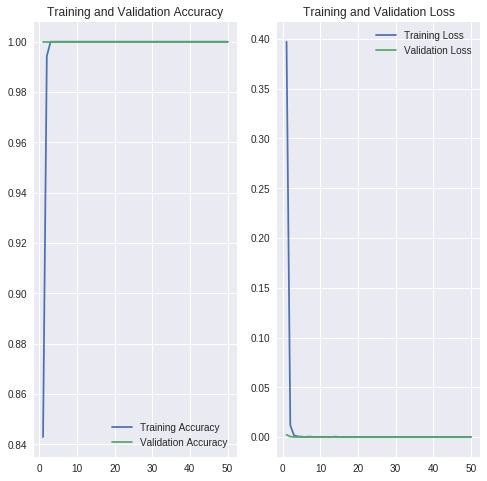

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
### Test accuracy and loss

score = model.evaluate(test_features, test_labels, verbose=0)

print("Test accuracy for VGG16: %.4f" % score[1])
print("Test loss for VGG16: %.8f" % score[0])

Test accuracy for VGG16: 1.0000
Test loss for VGG16: 0.00000072


 Use another pretrained model

In [0]:
#initialize a InceptionV3 model preloaded with weights trained on ImageNet

conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


87916544/87910968 [==============================] - 8s 0us/step


In [0]:
# Define a model
EPOCHS = 50

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 31,242,019
Trainable params: 31,207,587
Non-trainable params: 34,432
_________________________________________________________________


Here the number of parameters in the Inception_v3 model is 24,220,739.

In [0]:
conv_base.trainable = False

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

# Test data should not be augmented either
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')




Found 522 images belonging to 3 classes.
Found 212 images belonging to 3 classes.
Found 93 images belonging to 3 classes.


In [0]:

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
7/7 [==============================] - 12s 2s/step - loss: 5.3676 - acc: 0.6651
 - 30s - loss: 4.7710 - acc: 0.5441 - val_loss: 5.3676 - val_acc: 0.6651
Epoch 2/50
7/7 [==============================] - 11s 2s/step - loss: 3.8357 - acc: 0.7028
 - 23s - loss: 2.9602 - acc: 0.7088 - val_loss: 3.8357 - val_acc: 0.7028
Epoch 3/50
7/7 [==============================] - 11s 2s/step - loss: 1.7574 - acc: 0.8679
 - 23s - loss: 1.3183 - acc: 0.8678 - val_loss: 1.7574 - val_acc: 0.8679
Epoch 4/50
7/7 [==============================] - 11s 2s/step - loss: 0.1499 - acc: 0.9858
 - 23s - loss: 1.6541 - acc: 0.8563 - val_loss: 0.1499 - val_acc: 0.9858
Epoch 5/50
7/7 [==============================] - 11s 2s/step - loss: 1.8732 - acc: 0.8160
 - 23s - loss: 0.5377 - acc: 0.9291 - val_loss: 1.8732 - val_acc: 0.8160
Epoch 6/50
7/7 [==============================] - 11s 2s/step - loss: 0.4468 - acc: 0.9623
 - 23s - loss: 0.3764 - acc: 0.9598 - val_loss: 0.4468 - val_acc: 0.9623
Epoch 7/50
7/7 [

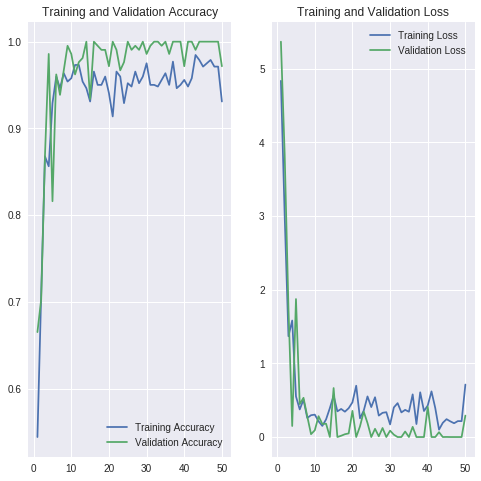

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
###Test accuracy and loss

score = model.evaluate(test_data_gen, verbose=0)

print("Test accuracy for InceptionV3: %.4f" % score[1])
print("Test loss for InceptionV3: %.8f" % score[0])

Test accuracy for InceptionV3: 0.9892
Test loss for InceptionV3: 0.08994376


In conclusion, all three methods above provide a high test accuracy since the size of our dataset is relatively small and the landmarks all look quite different from each other. 

## How small of a model (in terms of the number of parameters) to classify these images reasonably well

Here we try a couple of pretrained models and compare it with the VGG16 and InceptionV3 model that has been used above in terms of the number of parameters.

In [0]:
#initialize a InceptionV3 model preloaded with weights rtained on ImageNet

conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


80142336/80134624 [==============================] - 8s 0us/step


In [0]:
# Define a model, train it using the features extracted from VGG16
EPOCHS = 50

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1539      
Total params: 24,220,739
Trainable params: 24,220,739
Non-trainable params: 0
_________________________________________________________________


Here the number of parameters in the VGG19 model is 24,220,739.

In [0]:
conv_base.trainable = False

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

# Test data should not be augmented either
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 522 images belonging to 3 classes.
Found 212 images belonging to 3 classes.
Found 93 images belonging to 3 classes.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
7/7 [==============================] - 11s 2s/step - loss: 0.0688 - acc: 0.9670
 - 27s - loss: 1.5284 - acc: 0.6475 - val_loss: 0.0688 - val_acc: 0.9670
Epoch 2/50
7/7 [==============================] - 11s 2s/step - loss: 0.0158 - acc: 1.0000
 - 23s - loss: 0.1651 - acc: 0.9368 - val_loss: 0.0158 - val_acc: 1.0000
Epoch 3/50
7/7 [==============================] - 11s 2s/step - loss: 0.0066 - acc: 1.0000
 - 23s - loss: 0.0763 - acc: 0.9808 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 4/50
7/7 [==============================] - 11s 2s/step - loss: 0.0128 - acc: 1.0000
 - 24s - loss: 0.0569 - acc: 0.9751 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 5/50
7/7 [==============================] - 11s 2s/step - loss: 0.0031 - acc: 1.0000
 - 24s - loss: 0.0354 - acc: 0.9923 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 6/50
7/7 [==============================] - 11s 2s/step - loss: 0.0045 - acc: 1.0000
 - 23s - loss: 0.0364 - acc: 0.9904 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 7/50
7/7 [

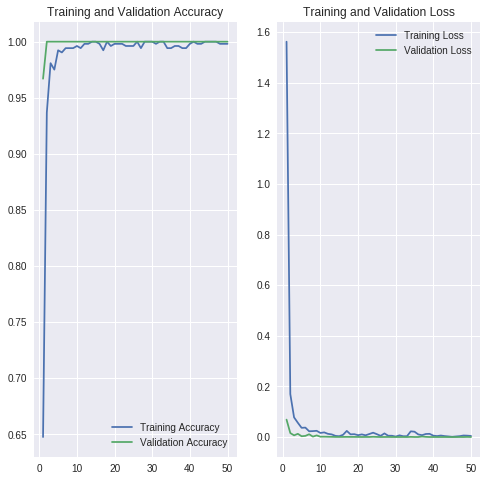

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
###Test accuracy and loss

score = model.evaluate(test_data_gen, verbose=0)

print("Test accuracy for VGG19: %.4f" % score[1])
print("Test loss for VGG19: %.8f" % score[0])

Test accuracy for VGG19: 1.0000
Test loss for VGG19: 0.00002934


Build our own model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

# Test data should not be augmented either
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 522 images belonging to 3 classes.
Found 212 images belonging to 3 classes.
Found 93 images belonging to 3 classes.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
7/7 [==============================] - 11s 2s/step - loss: 0.9250 - acc: 0.6509
 - 26s - loss: 1.1637 - acc: 0.3966 - val_loss: 0.9250 - val_acc: 0.6509
Epoch 2/50
7/7 [==============================] - 10s 1s/step - loss: 0.4637 - acc: 0.7028
 - 22s - loss: 0.7076 - acc: 0.6724 - val_loss: 0.4637 - val_acc: 0.7028
Epoch 3/50
7/7 [==============================] - 10s 1s/step - loss: 0.1885 - acc: 0.9387
 - 22s - loss: 0.3960 - acc: 0.8180 - val_loss: 0.1885 - val_acc: 0.9387
Epoch 4/50
7/7 [==============================] - 10s 1s/step - loss: 0.0993 - acc: 0.9434
 - 22s - loss: 0.1928 - acc: 0.9253 - val_loss: 0.0993 - val_acc: 0.9434
Epoch 5/50
7/7 [==============================] - 10s 1s/step - loss: 0.1654 - acc: 0.9528
 - 22s - loss: 0.1327 - acc: 0.9559 - val_loss: 0.1654 - val_acc: 0.9528
Epoch 6/50
7/7 [==============================] - 10s 1s/step - loss: 0.5223 - acc: 0.8113
 - 23s - loss: 0.1112 - acc: 0.9598 - val_loss: 0.5223 - val_acc: 0.8113
Epoch 7/50
7/7 [

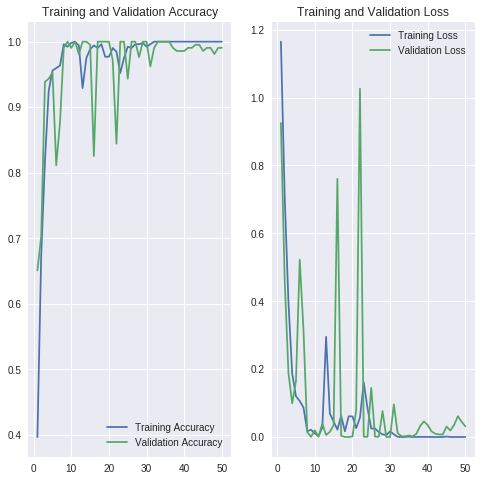

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
###Test accuracy and loss

score = model.evaluate(test_data_gen, verbose=0)

print("Test accuracy for designed model: %.4f" % score[1])
print("Test loss for designed model: %.8f" % score[0])

Test accuracy for designed model: 0.9892
Test loss for designed model: 0.02182250


It turned out that the model we designed on our own provides a great performance as well, which is probably because of the relatively small dataset we have. The number of parameters we have trained in this model is only 3,454,147.